In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np

from src.data_models.positional.waypoint import Waypoint, Waypoints
from src.waypoint_generation.waypoint_factory import WaypointFactory, WaypointAlgorithmEnum

In [44]:
with open("algorithms_output.json", 'r') as f:
    data = json.loads(json.load(f))
    
img = np.array(data['img'])

algs = {}
for key in WaypointAlgorithmEnum:
    key = str(key)
    try:        
        wps = Waypoints(data[key]['wps'])        
        algs[key] = {}
        algs[key]['time'] = data[key]['time']
        algs[key]['wps'] = wps
        print(f"{key} does exist ({len(wps)} wps)")
    except KeyError:
        print(f"{key} doesn't exist")

WaypointAlgorithmEnum.LHC_GW_CONV_E doesn't exist
WaypointAlgorithmEnum.PARALLEL_SWATHS doesn't exist
WaypointAlgorithmEnum.MODIFIED_LAWNMOWER doesn't exist
WaypointAlgorithmEnum.CONSTANT_SPEED does exist (5 wps)


WaypointAlgorithmEnum.CONSTANT_SPEED
86.34 units long
6.20s


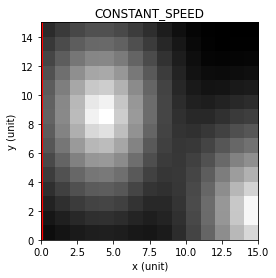

In [45]:
def plot(alg):
    fig, ax = plt.subplots()
    
    ax.imshow(img, interpolation=None,origin='bottom', extent=[0, img.shape[0], 0, img.shape[1]], cmap='gray')
    wps = algs[str(alg)]['wps'].toNumpyArray()
    
    dist = np.sum(np.linalg.norm(wps[1:] - wps[:-1],axis=1))
    
    
    
    ax.plot(wps[:,0],wps[:,1],'r',linewidth=3)
        
    ax.set_xlim(0,img.shape[0])
    ax.set_ylim(0,img.shape[1])
    ax.set_xlabel("x (unit)")
    ax.set_ylabel("y (unit)")
    
    s = str(alg).split('.')[1]
    ax.set_title(s)
    
    return fig,ax,dist
    
    
for key in algs.keys():
    fig,ax,dist = plot(key)
    print(f"{key}\n{dist:.2f} units long\n{algs[key]['time']:.2f}s")
    plt.show()
    algs[key]['dist'] = dist

In [32]:
def plot_bar(x,y,x_label,y_label):

    fig,ax = plt.subplots()
    plt.xticks(rotation=45)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.grid(True, linestyle='--', which='major',
                       color='grey', alpha=.25)
    ax.bar(x,y)
    return fig,ax

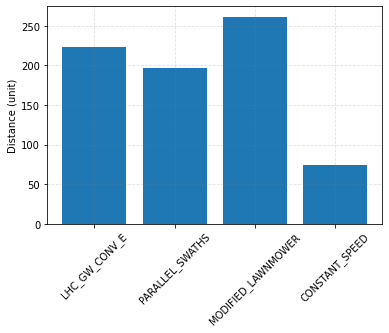

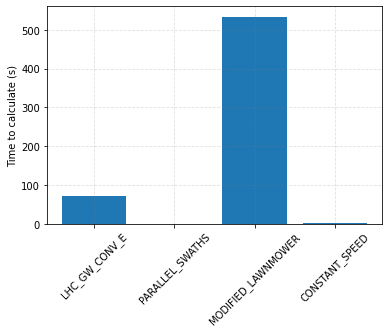

In [38]:
dists = [item[1]['dist'] for item in algs.items()]
times = [item[1]['time'] for item in algs.items()]
x = [str(s).split('.')[1] for s in algs.keys()]

fig,ax=plot_bar(x,dists,"","Distance (unit)")
fig.savefig("unit_distances_all.png")

fig,ax=plot_bar(x,times,"","Time to calculate (s)")
fig.savefig("time_to_calculate_all.png")